In [4]:
%matplotlib inline

from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt


# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect


# Reflect Tables into SQLAlchemy ORM

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# we can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# create our session (link) from python to the db
session = Session(engine)

# Exploratory Climate Analysis

* Design a query to retrieve the last 12 months of precipitation data and plot the results

* Calculate the date 1 year ago from the last data point in the database

* Perform a query to retrieve the data and precipitation scores

* Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# calc relevant dates
end_date = session.query(func.max(Measurement.date)).all()[0][0]
end_date_dt = dt.datetime.strptime(end_date, "%Y-%m-%d")
year_ago_dt = end_date_dt - dt.timedelta(days=365)

# create df with last 12 months precipitation data
last12_prcp = (session.query(Measurement.prcp, Measurement.date, Measurement.station).filter(Measurement.date > year_ago_dt).order_by(Measurement.date).all())
last12_prcp_df = pd.DataFrame(last12_prcp).dropna().set_index("date")
last12_prcp_df.head(10)


,prcp,station
date,,
2016-08-24,0.08,USC00519397
2016-08-24,2.15,USC00513117
2016-08-24,2.28,USC00514830
2016-08-24,1.22,USC00519523
2016-08-24,2.15,USC00519281
2016-08-24,1.45,USC00516128
2016-08-25,0.08,USC00519397
2016-08-25,0.08,USC00513117
2016-08-25,0.00,USC00514830


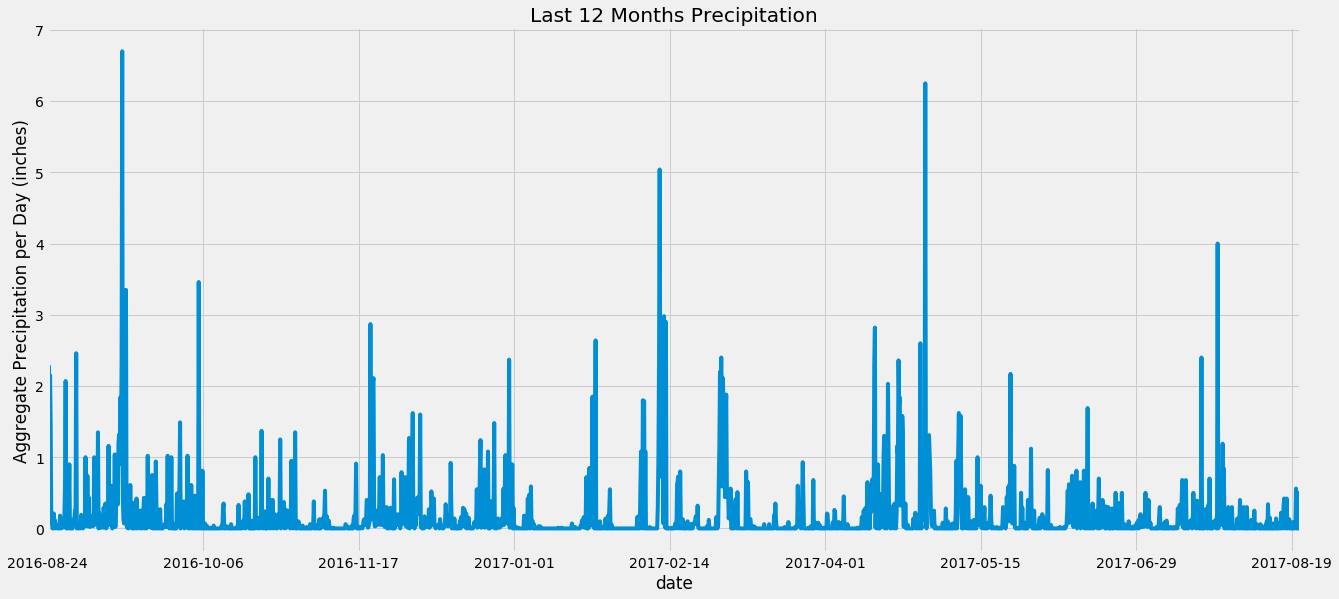

In [19]:
# plot results

last12_prcp_df.plot()
plt.title("Last 12 Months Precipitation")
plt.ylabel("Aggregate Precipitation per Day (inches)")
plt.rcParams["figure.figsize"] = (20,9)
plt.legend().remove()
plt.show()

In [20]:
#print summary data from df
last12_prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [23]:
# design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Station.id)).all()[0][0]
print(station_count)

9


In [30]:
# most active stations by row count listed in desc order
stations = session.query(func.count(Measurement.id).label("row_count"), Measurement.station).group_by(Measurement.station).all()
stations_df = pd.DataFrame(most_active).sort_values(by=["row_count"], ascending=False).set_index("station")
stations_df

,row_count
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [37]:
# using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

# define most active station
max_station = session.query(func.count(Measurement.id).label("row_count"), Measurement.station).group_by(Measurement.station).order_by("row_count").all()
max_station_id = max_station[-1][1]

#calculate temp data
min_temp = session.query(Measurement.station, func.min(Measurement.tobs)).filter(Measurement.station == max_station_id).all()
max_temp = session.query(Measurement.station, func.max(Measurement.tobs)).filter(Measurement.station == max_station_id).all()
avg_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).filter(Measurement.station == max_station_id).all()
all_temp_data = [min_temp[0][1], max_temp[0][1], avg_temp[0][1]]
all_temp_data

[54.0, 85.0, 71.66378066378067]

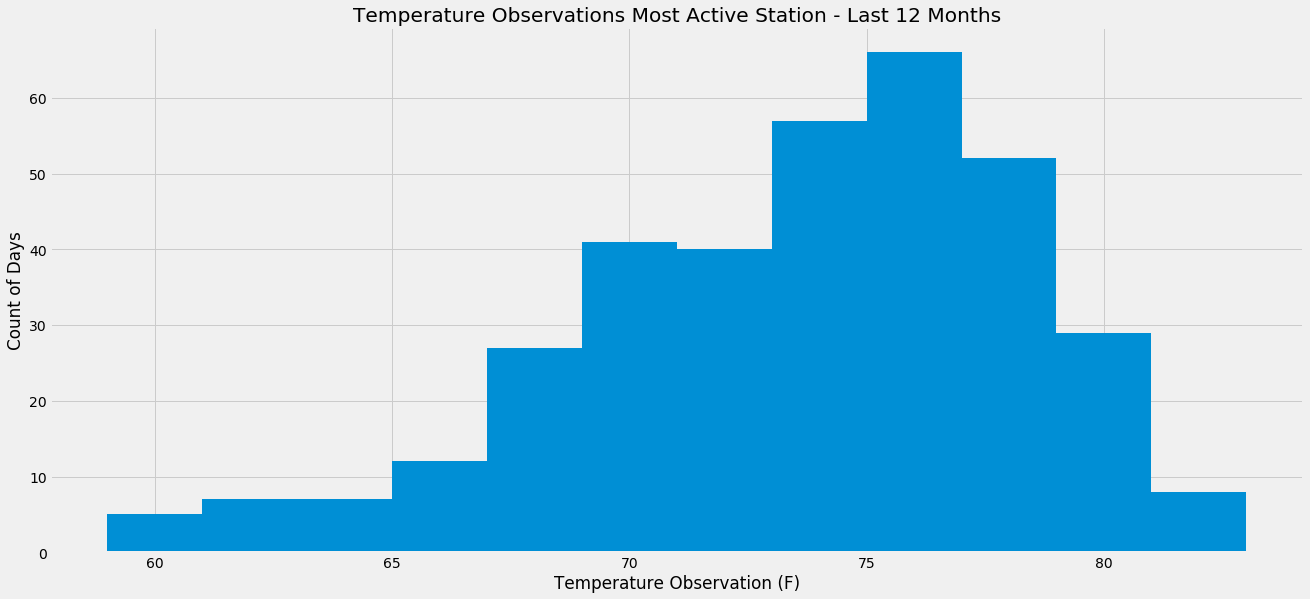

In [54]:
# query and display last 12 months temp observations for most active station as a histogram

#create df of most active station temp obervations for last 12 months
max_station_last12 = (session.query(Measurement.tobs, Measurement.date, Measurement.station).filter(Measurement.date > year_ago_dt)\
             .filter(Measurement.station == max_station_id).order_by(Measurement.date).all())
max_station_last12_df = pd.DataFrame(max_station_last12).dropna().set_index("date")


# calc temp ranges and bin
min_temp = max_station_last12_df["tobs"].min()
max_temp = max_station_last12_df["tobs"].max()
step = (max_temp-min_temp)/13
bins = (list(np.arange(min_temp,max_temp,step)))
bin_labels = ["59-60", "60-62", "62-64", "64-66", "66-68", "68-70", "70-71", "71-73", "73-75", "75-77", "77-79", "79-81"]
max_station_last12_df["temp_bins"] = pd.cut(max_station_last12_df["tobs"], bins, labels=bin_labels)

#plot results as histogram
plt.hist(x=max_station_last12_df["tobs"], bins=12)
plt.title("Temperature Observations Most Active Station - Last 12 Months")
plt.xlabel("Temperature Observation (F)")
plt.ylabel("Count of Days")
plt.rcParams["figure.figsize"] = (20,9)
plt.show()